In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN
import torch
from IPython.display import clear_output

In [2]:
data = pd.read_csv("./../DATA/creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.drop(["Time", "Class"],axis=1, inplace= True)

In [5]:
cuda = True if torch.cuda.is_available() else False
cuda

False

In [6]:
from sklearn.preprocessing import MinMaxScaler as mms
num_scaler = mms(feature_range=(-1,1))
columns = data.columns.tolist()
data[columns] = num_scaler.fit_transform(data[columns])

In [7]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.870385,0.532981,0.762730,-0.373955,0.526877,-0.464663,-0.466370,0.572888,-0.049377,0.021201,...,0.165884,0.122369,0.045984,0.327586,-0.217495,0.170244,-0.210886,-0.162048,-0.374607,-0.988352
1,0.957084,0.540133,0.680597,-0.456407,0.532241,-0.475617,-0.470249,0.572597,-0.092038,0.010535,...,0.159060,0.115680,-0.039526,0.333876,-0.327120,0.174581,-0.107974,-0.167310,-0.373155,-0.999791
2,0.870434,0.506235,0.736282,-0.462469,0.524658,-0.437756,-0.459646,0.576085,-0.178795,0.026036,...,0.171710,0.130955,0.092060,0.357878,-0.421292,0.119030,-0.194546,-0.169021,-0.376177,-0.970522
3,0.883756,0.530608,0.736967,-0.572678,0.531294,-0.448882,-0.466394,0.578868,-0.170001,0.015170,...,0.156100,0.119467,0.020554,0.325214,-0.552348,0.228491,-0.221607,-0.164663,-0.371258,-0.990386
4,0.877234,0.553040,0.728501,-0.460407,0.525950,-0.472032,-0.462064,0.564967,-0.018101,0.048606,...,0.169231,0.122655,0.094541,0.326784,-0.197460,0.132685,0.014994,-0.158878,-0.365020,-0.994551


In [8]:
class Generator(nn.Module) :
    def __init__(self,layers) :
        super().__init__()
        self.fc = self.make_model(layers,sn=True,bn=True,dropout=False)
        self.fc.apply(self.init_weights)
        self.num_scaler = nn.Tanh()
    
    def forward(self ,x ):
        x = self.fc(x)
        x = self.num_scaler(x)
        return x

    def init_weights(self,m):
        if type(m) == nn.Linear:
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.0)
            
    def make_model(self, layers , sn=True, bn =False,dropout=True) :
        model = []
        for idx , layer in enumerate(layers[1:]) :
            mod = nn.Linear(layers[idx], layer)
            if sn == True :
                mod = SN(mod)
            model.append(mod)
            if (idx+1) == len(layers[1:]) :
                pass
            else :
                if dropout == True :
                    model.append(nn.AlphaDropout(0.8))
                if bn == True :
                    model.append(nn.BatchNorm1d(layer))
                model.append(nn.SELU())
        return nn.Sequential(*model)
    
class Discriminator(nn.Module) :
    def __init__(self,layers) :
        super().__init__()
        self.fc = self.make_model(layers,sn=True,bn=True,dropout=False)
        self.fc.apply(self.init_weights)
        self.num_scaler = nn.Tanh()
    
    def forward(self ,x ):
        x = self.fc(x)
        return x
    
    def init_weights(self,m):
        if type(m) == nn.Linear:
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.0)
            
    def make_model(self, layers , sn=True, bn =False,dropout=True) :
        model = []
        for idx , layer in enumerate(layers[1:]) :
            mod = nn.Linear(layers[idx], layer)
            if sn == True :
                mod = SN(mod)
            model.append(mod)
            if (idx+1) == len(layers[1:]) :
                pass
            else :
                if dropout == True :
                    model.append(nn.AlphaDropout(0.8))
                if bn == True :
                    model.append(nn.BatchNorm1d(layer))
                model.append(nn.SELU())
        return nn.Sequential(*model)

In [18]:
from torch.utils.data import Dataset, DataLoader, random_split
class TabularDataset(Dataset) :
    def __init__(self, X) :
        self.X = X
    def __len__(self) :
        return len(self.X)
    def __getitem__(self,idx) :
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return self.X[idx,:].astype(np.float32)
    
class origian_gan(object)  :
    def __init__(self,) :
        self.adversarial_loss = nn.BCEWithLogitsLoss()
        self.store = {"epoch" : [], "dloss" : [], "gloss" : []}
        self.load_n = 0
        
    def build_graph(self, g_args , num_scaler) :
        self.latent_dim , g_layers , d_layers , g_lr, d_lr, b1, b2, cuda = g_args
        self.g_args = [self.latent_dim , g_layers , d_layers]
        self.num_scaler = num_scaler
        self.generator= Generator(layers=g_layers)
        self.discriminator= Discriminator(layers=d_layers)
        if cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()
        self.optimG = torch.optim.Adam(self.generator.parameters(), 
                                       lr=g_lr, betas=(b1, b2))
        self.optimD = torch.optim.Adam(self.discriminator.parameters(), 
                                       lr=d_lr, betas=(b1, b2))
        self.Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    
    def sample_z(self,row) :
        z = Variable(self.Tensor(np.random.normal(0, 1, (row, self.latent_dim))))
        return z
    
    def inference(self,row , cuda = False , load_path = None) :
        self.Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        if load_path is not None :
            if self.load_n == 0 :
                self.load_model(load_path)
                self.load_n = 1
        z = self.sample_z(row)
        result = self.generator(z).detach().numpy()
        return result
        
    def generate_label_z(self, row ) :
        valid = Variable(self.Tensor(row, 1).fill_(1.0), requires_grad=False)
        fake = Variable(self.Tensor(row, 1).fill_(0.0), requires_grad=False)
        z = self.sample_z(row)
        return valid , fake , z
        
    def train(self, data , g_args , num_scaler , n_epochs = 100, batch_size = 500) :
        self.build_graph(g_args , num_scaler)
        trainset = TabularDataset(data.values)
        trainloader = DataLoader(trainset, batch_size=batch_size, 
                                 shuffle=True,num_workers=20)
        for epoch in range(n_epochs):
            for i, batch_data in enumerate(trainloader):
                real_data = Variable(batch_data.type(self.Tensor))
                valid , fake , z = self.generate_label_z(batch_data.size()[0])
                self.optimG.zero_grad()
                gen_data = self.generator(z)
                g_loss = self.adversarial_loss(self.discriminator(gen_data), valid)
                g_loss.backward()
                self.optimG.step()
                self.optimD.zero_grad()
                real_loss = self.adversarial_loss(self.discriminator(real_data), valid)
                fake_loss = self.adversarial_loss(self.discriminator(gen_data.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                self.optimD.step()
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %.4f] [G loss: %.4f]"
                    % (epoch, n_epochs, i, len(trainloader), d_loss.item(), g_loss.item())
                , end="\r")
                
            eval_data = self.Tensor(data.values)
            valid , fake , z = self.generate_label_z(eval_data.size()[0])
            gen_data = self.generator(z)
            g_loss = self.adversarial_loss(self.discriminator(gen_data), valid)
            real_loss = self.adversarial_loss(self.discriminator(eval_data), valid)
            fake_loss = self.adversarial_loss(self.discriminator(gen_data),fake)
            d_loss = (real_loss + fake_loss) / 2
            self.store["epoch"].append(epoch)
            self.store["dloss"].append(d_loss.item())
            self.store["gloss"].append(g_loss.item())
            self.vis()
            self.save_model(save_path="./gan_model.pth")
    
    def vis(self,) :
        clear_output()
        plt.plot(self.store["epoch"], self.store["dloss"], label ="dloss")
        plt.plot(self.store["epoch"], self.store["gloss"], label ="gloss")
        plt.legend()
        plt.show()
    
    def save_model(self,save_path) :
        save_path = "./gan_model.pth"
        info = {
            "g_args" : self.g_args , 
            "num_scaler" : self.num_scaler,
            "generator_state_dict" : self.generator.state_dict(),
            "discriminator_state_dict" : self.discriminator.state_dict(),
            "generator_optim_state_dict" : self.optimG.state_dict(),
            "discriminator_optim_state_dict" : self.optimD.state_dict()}
        torch.save(info, save_path)
    
    def load_model(self,load_path = "./gan_model.pth") :
        self.checkpoint = torch.load(load_path)
        self.latent_dim , g_layers, d_layers = self.checkpoint["g_args"]
        self.num_scaler = self.checkpoint["num_scaler"]
        self.generator = Generator(layers = g_layers)
        self.discriminator = Discriminator(layers = d_layers)
        
        self.discriminator.load_state_dict(self.checkpoint["discriminator_state_dict"])
        self.generator.load_state_dict(self.checkpoint["generator_state_dict"])

In [19]:
ori_gan = origian_gan()

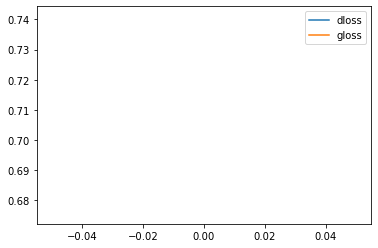

KeyboardInterrupt: 

In [20]:
latent_dim = 10
total_col_n = len(columns)
g_layers = [latent_dim, 20, 30, total_col_n]
d_layers = [total_col_n , 20 ,10,1]
g_lr = 1e-4
d_lr = 1e-5
b1 , b2 = 0.5 , 0.999
cuda = True if torch.cuda.is_available() else False
g_args = [latent_dim, g_layers , d_layers , g_lr, d_lr, b1, b2, cuda] 
scaler = num_scaler
ori_gan.train(data, g_args , scaler, n_epochs=200, batch_size = 300)

In [21]:
del ori_gan
ori_gan

NameError: name 'ori_gan' is not defined

In [23]:
ori_gan = origian_gan()

In [26]:
ori_gan.inference(row = 100  , cuda = cuda, load_path="./gan_model.pth")

array([[ 0.971527  , -0.58575076, -0.7673694 , ...,  0.45700347,
         0.28068584, -0.5485998 ],
       [-0.33350462,  0.07272428,  0.03030981, ...,  0.33195886,
         0.41954464,  0.61596596],
       [-0.42303717,  0.64501405,  0.43706402, ..., -0.18789387,
        -0.21473606,  0.6313253 ],
       ...,
       [-0.24014457,  0.62147963,  0.4474559 , ...,  0.26185125,
        -0.5990192 , -0.03740655],
       [-0.64913243, -0.08135279,  0.7817026 , ..., -0.37349516,
        -0.3349383 ,  0.2207043 ],
       [-0.26652536, -0.18160778, -0.3385083 , ...,  0.41758123,
        -0.64169693, -0.78257155]], dtype=float32)